## Implementation Transformers From Scratch

Develop 3 models : encoder, decoder, encoder-decoder

Modules : 
- MultiHead Attention Block
- Transformer Block
- Possitional Encoding Block
- Encoder Block

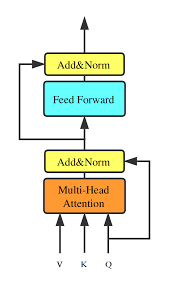

In Transformer Block - We need to create 4 components in init method :
- MultiHeadAttention
- LayerNormalization
- LayerNormalization
- FeedForward Network which can be ANN or some other network as well

In Encoder Block - We need below components -
- Embedding
- PositionalEncoding
- List of TransformerBlocks
- LinearLayer

## Building Encoder Module

### MultiHeadAttention Class 

In [5]:
import math
import torch
import torch.nn as nn 
from torch.utils.data import dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


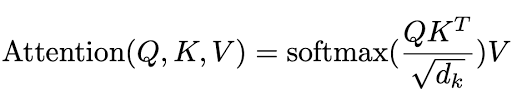

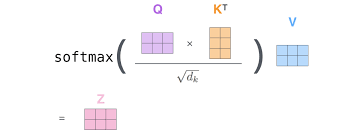

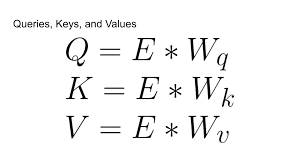

- W is different attention weight
- E are different inputs

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_k,d_model,n_heads):
        super().__init__()
        self.d_k = d_k # dimensions of query and value vectors ; since d_k = d_v that's why only using d_k here
        self.n_heads = n_heads # Number of attention heads 
        self.key = nn.Linear(d_model,d_k * n_heads)  # Here we are creating a linear layers
        self.query = nn.Linear(d_model,d_k * n_heads) # d_model - dimension of input feature vector
        self.value = nn.Linear(d_model,d_k * n_heads) # d_k - is size of output 
        # (d_k) represents the dimensionality of the key, query, and value vectors 
        # and we are taking it to all n_heads so the output will be d_k* n_heads  
        # Final Linear Layer , Here we concatenate the all attention layers outputs 
        self.fc = nn.Linear(d_k * n_heads, d_model) # here input size is d_k * n_heads & output size is d_model
    
    # size of inputs and output of model is : d_model

    def forward(self,q,k,v,mask=None):
        q = self.query(q) # Shape N x T x (hd_k)
        k = self.query(k) # Shape N x T x (hd_k)
        v = self.query(v) # Shape N x T x (hd_v)


        # Storing batch size N and sequence length T
        N = q.shape[0]
        T = q.shape[1]

        # change the shape from (N,T,h,d_k) to (N,h,T,d_k) in order to make matix multiplication correctly
        q = q.view(N,T,self.n_heads,self.d_k).transpose(1,2) 
        # view is to repalce the tensor
        # transpose(1,2) means swap the dimensions at index 1 & 2 with each other
        k = k.view(N,T,self.n_heads,self.d_k).transpose(1,2) 
        v = v.view(N,T,self.n_heads,self.d_k).transpose(1,2) 


        # Now compute attention :  Attention(Q, K) = softmax(Q * K^T / sqrt(d_k))
        attention_scores = q @ k.transpose(-2,-1) / math.sqrt(self.d_k)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(
                mask[:,None,None,:]==0,float("-inf")
            )
        attention_weight = F.softmax(attention_scores,dim=-1)

        # Compute attention weighted values 
        # (N,h,T,T) x (N,h,T,d_k) ---> (H,h,T,d_k)
        A = attention_weight @ v

        # Reshape it back before final linear layer
        A = A.transpose(1,2) # (N,T,h,d_k)
        A = A.contiguous().view(N,T,self.d_k*self.n_heads) # (N,T,h*d_k)

        # Projection
        return self.fc(A)

### TransformerBlock Class

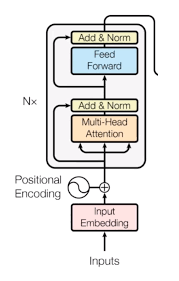

Transformer Block will have below components -
- 2 Liner Layers 
- 1 MultiHeadAttention
- ANN FeedForward Network
- DropOut Layer


In [7]:
class TransformerBlock(nn.Module):
    def __init__(self,d_k,d_model,n_heads,dropout_prob=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_k=d_k,d_model=d_model,n_heads=n_heads)
        self.ann = nn.Sequential(
            nn.Linear(d_model,d_model*4),
            nn.GELU(),
            nn.Linear(d_model*4,d_model),
            nn.Dropout(dropout_prob)
        )
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self,x,mask=None):
        x = self.ln1(x + self.mha(x,x,x,mask)) # Using residual connection
        x = self.ln2(x + self.ann(x)) # value passed to feed forward network (ANN)
        x = self.dropout(x)
        return x


### PositionalEncoding Class

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_length=2048,dropout_prob = 0.1 ):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)
        # Now compute positional encoding using formula
        position = torch.arange(max_length).unsqueeze(1)
        exp_term = torch.arange(0,d_model,2)
        div_term = torch.exp(exp_term * (-math.log(10000.0)/d_model))
        pe = torch.zeros(1,max_length,d_model)
        pe[0,:,0::2] = torch.sin(position* div_term)
        pe[0,:,1::2] = torch.cos(position*div_term)
        self.register_buffer("pe",pe)
    
    def forward(self,x):
        x = x + self.pe[:,:x.size(1),:]
        return self.dropout(x)

### Implementation of Transformer Encoder 

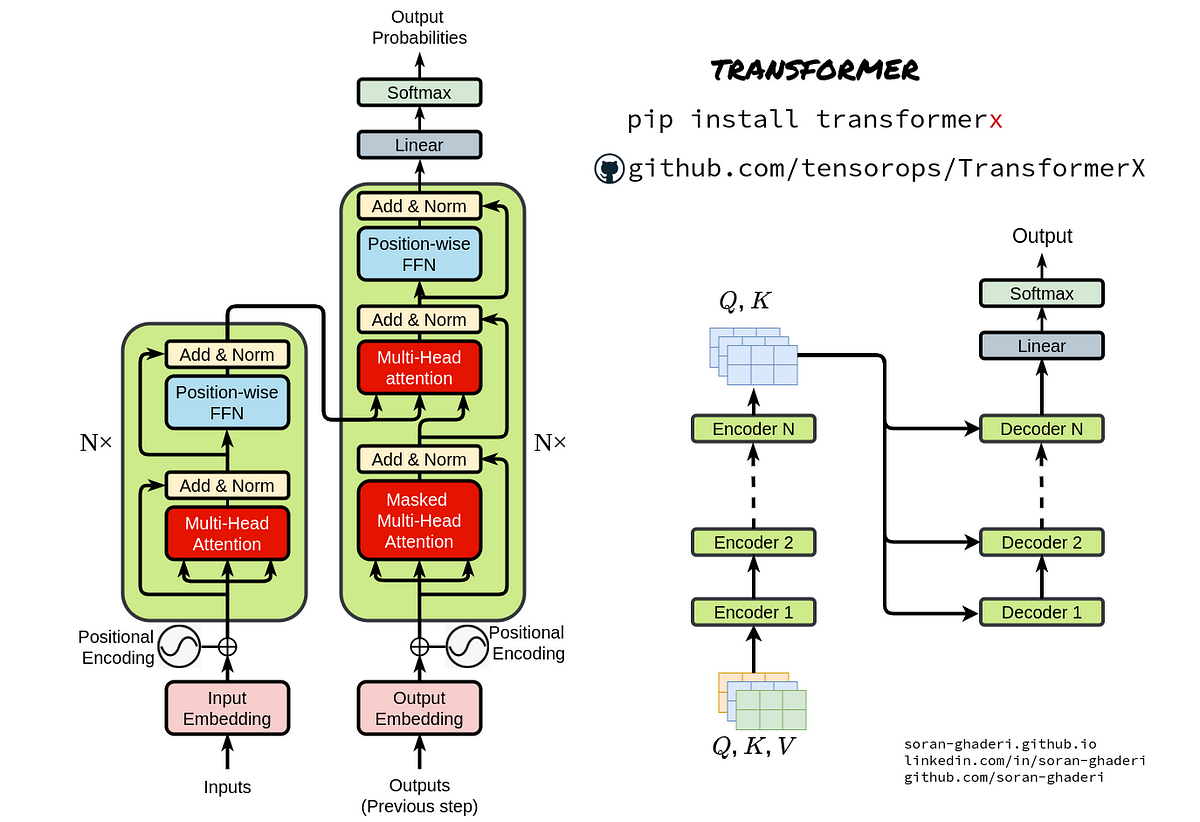 

 ### Encoder Class

In [33]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 max_len, # max sequence length
                 d_k,
                 d_model,
                 n_heads,  # no. of attention heads
                 n_layers, # no. of transformer blocks
                 n_classes,
                 dropout_prob
                 ):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size,d_model)  # This will convert tokens into vectors 
        self.pos_encoding = PositionalEncoding(d_model=d_model,max_length=max_len,dropout_prob=dropout_prob) # Implement positional encoding
        transformer_blocks = [
            TransformerBlock(
                d_k=d_k,
                d_model=d_model,
                n_heads=n_heads,
                dropout_prob=dropout_prob
            ) for _ in range(n_layers)
        ]
        self.transformer_blocks = nn.Sequential(*transformer_blocks) # To create transformer blocks 
        self.ln = nn.LayerNorm(d_model) # Linear Layers 
        self.fc = nn.Linear(d_model,n_classes) # Linear Layers 

    def forward(self,x,mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
            x = block(x,mask)
        
        # many to one ( x has shape N x T x D)
        x = x[:,0,:]
        x = self.ln(x)
        x = self.fc(x)
        return x

#### Testing Transformer Encoder Model Using Random Data

In [34]:
model  =  Encoder(vocab_size=20000,max_len=1024,d_k=16,d_model=64,n_heads=4,n_layers=2,n_classes=5,dropout_prob=0.1)

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
device

device(type='cuda', index=0)

In [37]:
model.to(device)

Encoder(
  (embedding): Embedding(20000, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, 

In [40]:
x = np.random.randint(0,20000,size=(8,512))
x_t = torch.tensor(x).to(device)
mask = np.ones((8,512))
mask[:,256:] = 0
mask_t = torch.tensor(mask).to(device)


In [41]:
y = model(x_t,mask_t)

In [48]:
y.shape  # means batch size 8 and 5 classes

torch.Size([8, 5])

### Using Above Model Architecture For Training

In [60]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
from transformers import TrainingArguments, Trainer


In [61]:
checkpoint = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


In [62]:
raw_dataset = load_dataset("glue","sst2")


In [63]:
def tokenize_func(batch):
    return tokenizer(batch['sentence'],truncation=True)


In [64]:
tokenized_dataset = raw_dataset.map(tokenize_func,batched=True)


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [65]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [66]:
data_collator

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [67]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})

In [68]:
tokenized_dataset = tokenized_dataset.remove_columns(['sentence','idx'])
tokenized_dataset = tokenized_dataset.rename_column('label','labels')

In [69]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})

In [70]:
from torch.utils.data import DataLoader

In [73]:
train_loader = DataLoader(
    tokenized_dataset['train'],
    shuffle = True,
    batch_size = 32,
    collate_fn = data_collator
)

valid_loader = DataLoader(
    tokenized_dataset['validation'],
    shuffle = True,
    batch_size = 64,
    collate_fn = data_collator)

In [75]:
for batch in train_loader:
    for k,v in batch.items():
        print("k:",k,"v shape:",v.shape)
    break

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


k: labels v shape: torch.Size([32])
k: input_ids v shape: torch.Size([32, 34])
k: attention_mask v shape: torch.Size([32, 34])


In [76]:
set(tokenized_dataset['train']['labels'])

{0, 1}

In [77]:
tokenizer.vocab_size

28996

In [78]:
tokenizer.max_model_input_sizes

{'distilbert-base-uncased': 512,
 'distilbert-base-uncased-distilled-squad': 512,
 'distilbert-base-cased': 512,
 'distilbert-base-cased-distilled-squad': 512,
 'distilbert-base-german-cased': 512,
 'distilbert-base-multilingual-cased': 512}

In [79]:
model = Encoder(
    vocab_size=tokenizer.vocab_size,
    max_len=tokenizer.max_model_input_sizes[checkpoint],
    d_k=16,
    d_model=64,
    n_heads=4,
    n_layers=2,
    n_classes=2,
    dropout_prob=0.1
)

In [80]:
model.to(device)

Encoder(
  (embedding): Embedding(28996, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, 

In [84]:
# Loss & Optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [86]:
from datetime import datetime

#### Training 

In [97]:
def train(model,criterion,optimizer,train_loader,valid_loader,epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        model.train()
        t0=datetime.now()
        train_loss = 0
        n_train = 0
        for batch in train_loader:
            # Move data to GPU
            batch = {k:v.to(device) for k,v in batch.items()}

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward Pass to compute the loss
            outputs = model(batch['input_ids'], batch['attention_mask'])
            loss = criterion(outputs,batch['labels'])

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*batch['input_ids'].size(0)
            n_train += batch['input_ids'].size(0)

        # Get average train loss
        train_loss += train_loss / n_train

        model.eval()


        test_loss = 0
        n_test = 0
        for batch in valid_loader:
            # Move data to GPU
            batch = {k:v.to(device) for k,v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            loss = criterion(outputs,batch['labels'])
            test_loss += loss.item()*batch['input_ids'].size(0)
            n_test += batch['input_ids'].size(0)
        test_loss = test_loss/n_test

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0 

        print(f"Epoch {it+1}/{epochs},Train Loss : {train_loss:.4f},\
              Test Loss: {test_loss:.4f}, Duration:{dt}")
        

    return train_losses, test_losses

In [98]:
train_losses, test_losses = train(model=model,criterion=criterion,
                                  optimizer=optimizer,train_loader=train_loader,
                                  valid_loader=valid_loader,epochs=4)

Epoch 1/4,Train Loss : 35142.4519,              Test Loss: 0.4817, Duration:0:00:14.369701
Epoch 2/4,Train Loss : 23246.7706,              Test Loss: 0.4552, Duration:0:00:13.780801
Epoch 3/4,Train Loss : 19303.7031,              Test Loss: 0.5046, Duration:0:00:14.439295
Epoch 4/4,Train Loss : 17208.4564,              Test Loss: 0.4809, Duration:0:00:14.360791


In [100]:
## Accuracy 

model.eval()
n_correct = 0
n_total = 0

for batch in train_loader:
    # Move to GPU
    batch = {k:v.to(device) for k,v in batch.items()}

    # Forward Pass
    outputs = model(batch['input_ids'], batch['attention_mask'])

    # Get Predictions
    _, predictions = torch.max(outputs,1)

    # Update Counts
    n_correct  += (predictions ==batch['labels']).sum().item()
    n_total += batch['labels'].shape[0]

train_acc = n_correct/n_total

n_correct = 0
n_total = 0

for batch in valid_loader:
    batch = {k:v.to(device) for k,v in batch.items()}
    outputs = model(batch['input_ids'], batch['attention_mask'])
    _, predictions = torch.max(outputs,1)
    n_correct  += (predictions ==batch['labels']).sum().item()
    n_total += batch['labels'].shape[0]

test_acc = n_correct/n_total

print(f"Train Accuracy : {train_acc:.4f}, Test Accuracy:{test_acc:.4f}")


Train Accuracy : 0.9200, Test Accuracy:0.7924
